# Analisis exploratorio de datos (EDA)

El propósito de este apartado es llevar a cabo un profundo análisis de los datos recabados gracias a FinnHub y AlphaVantage, con la finalidad de comprender mejor su naturaleza y relevancia. Esto nos ayudará a poder tomar decisiones informadas a la hora de llevar a cabo el preprocesado y la creación de modelos, teniendo en cuenta cuáles son las variables que más nos interesan o la correlación entre las mismas.

Comenzaremos importando todas las librerías necesarias para realizar esta actividad.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Además, importamos los datos para el estudio

In [2]:
financial_df = pd.read_csv('data/fundamentals.csv', sep=',')

## Feature Analysis

Una vez tenemos cargados los datos procedemos a analizarlos. Primeramente llevamos a cabo un análisis completo de todos los atributos, donde conoceremos los tipos de datos disponibles, sus estadísticas principales y las posibles correlaciones.

CITA: @article{sahoo2019exploratory,
  title={Exploratory data analysis using Python},
  author={Sahoo, Kabita and Samal, Abhaya Kumar and Pramanik, Jitendra and Pani, Subhendu Kumar},
  journal={International Journal of Innovative Technology and Exploring Engineering},
  volume={8},
  number={12},
  pages={4727--4735},
  year={2019}
}

### Data types

En el análisis de los atributos, empezamos comprobando el tipo de los mismos, así como cuantos valores no nulos tenemos.

In [3]:
# Comprobamos los tipos de datos disponibles
print(financial_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64635 entries, 0 to 64634
Data columns (total 74 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Unnamed: 0                                                 64635 non-null  int64  
 1   fiscalDateEnding                                           64635 non-null  object 
 2   totalCurrentAssets                                         45331 non-null  float64
 3   totalAssets                                                55151 non-null  float64
 4   currentAccountsPayable                                     35609 non-null  float64
 5   totalCurrentLiabilities                                    45113 non-null  float64
 6   commonStock                                                50333 non-null  float64
 7   retainedEarnings                                           53105 non-null  float64
 8   totalS

Como era de esperar todas las columnas son float64; exceptuando fiscalDateEnding, reportedCurrency, symbol, sector e industria. Además tenemos una columna de índice "unnamed: 0". Por otro lado, tenemos un total de 64635 filas de información, con 72 "features" o atributos distintos, algunos de ellos contienen muchos null values, por tanto, serán variables que no aportarán casi información. Algunos ejemplos serían shorTermDebt, netIncomeFromcontinuingOperations, entre otros.

Cabe destacar que casi todas las variables tienen algunos valores faltantes, por tanto, se necesitará llevar a cabo una correcta depuración de los datos a través de la eliminación e imputación de atributos. En el caso de los cash flows, contamos con una gran cantidad de valores faltantes, debido a que es una métrica con un gran potencial informativo, intentaremos durante el preprocesado calcular los valores faltantes.

### Main statistics

A continuación, obtenemos una descripcion de los datos más relevantes, como son los resultados finales de los estados financieros o algunos de los ratios computados

In [4]:
# Obtenemos una descripcion de los datos más relevantes
columns_to_describe = ['totalAssets', 'netIncome', 'totalLiabilities', 'sharePrice', 'totalShareholderEquity', 'changeInCashAndCashEquivalents', 'ROA', 'EPS']
print(financial_df[columns_to_describe].describe())

        totalAssets     netIncome  totalLiabilities    sharePrice  \
count  5.515100e+04  5.083000e+04      6.219800e+04  6.147500e+04   
mean   4.549746e+09  1.159560e+08      3.229495e+09  9.341551e+06   
std    2.881059e+10  1.454275e+09      2.211128e+10  9.515364e+08   
min   -5.921384e+09 -1.250000e+10     -2.465100e+10  3.000000e-04   
25%    7.503469e+07 -1.021925e+07      2.250325e+07  7.410000e+00   
50%    4.026870e+08  2.295000e+05      1.868520e+08  1.690380e+01   
75%    1.806526e+09  1.911600e+07      1.183863e+09  4.025000e+01   
max    4.831333e+12  7.908200e+10      4.132105e+12  1.618176e+11   

       totalShareholderEquity  changeInCashAndCashEquivalents           ROA  \
count            5.188600e+04                    2.328700e+04  5.054700e+04   
mean             1.374187e+09                    2.280225e+07           NaN   
std              8.578987e+09                    8.580501e+08           NaN   
min             -8.768000e+09                   -4.847700e+10 

c:\Users\xavic\Escritorio\TFG_MLStockRating\.venv\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\xavic\Escritorio\TFG_MLStockRating\.venv\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


A través de estos números no podemos sacar muchas conclusiones, sin embargo, sí podemos detectar ciertas anomalías:
- La media de precios está completamente disparada, con un valor de 9.34e+06. Si nos fijamos en los quartiles 1 y 3 los valores son de 7.41$ y 40.25$ respectivamente, por tanto, una media tan alta nos indica que hay valores muy atípicos que provocan esta gran inflación de los datos.
- Los ratios contienen valores infinitos (ya que puede haber divisiones entre 0, valores nulos, etc.), lo cual dificulta el cálculo de las estadísticas básicas.

Estas observaciones también tendrán que ser tomadas en cuenta en el preprocesado. Por ahora, simplemente quitaremos los valores infinitos en los ratios para poder llevar a cabo un correcto análisis gráfico posteriormente.

In [5]:
# Quitamos valores infinitos
financial_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Obtenemos una descripcion de los ratios
columns_to_describe = ['ROA', 'ROE', 'EPS', 'P/E', 'bookValue', 'currentRatio', 'totalAssetsTurnover', 'inventoryTurnover']
print(financial_df[columns_to_describe].describe())

                ROA           ROE           EPS           P/E     bookValue  \
count  5.052700e+04  4.833500e+04  4.510400e+04  4.451700e+04  4.753400e+04   
mean  -4.197336e+02 -4.329519e+02 -2.238940e+02 -2.481297e+05  5.850364e+04   
std    1.064813e+05  1.088656e+05  2.152570e+05  4.549118e+07  2.551156e+06   
min   -2.380400e+07 -2.380400e+07 -2.380400e+07 -9.567484e+09 -1.815542e+07   
25%   -1.202546e-01 -1.595883e-01 -3.399066e+02 -2.994771e-02  3.048654e+01   
50%    1.067135e-03  1.463818e-02 -2.737710e-03  0.000000e+00  9.612859e+02   
75%    1.846662e-02  7.113904e-02  4.743600e+01  4.759223e-01  4.676189e+03   
max    2.470200e+06  2.470200e+06  1.607770e+07  2.597421e+05  1.720512e+08   

       currentRatio  totalAssetsTurnover  inventoryTurnover  
count  44817.000000         10535.000000       10862.000000  
mean       5.055005            -5.123162           7.381662  
std       49.585469           103.311548          56.359526  
min        0.000000         -5532.911528

Como se puede ver, en este caso, a pesar de haber eliminado valores infinitos seguimos teniendo valores excesivamente atípicos como máximos y mínimos que provocan que las medias se alejen en muchos casos de los valores interquartílicos. Por tanto, en los ratios también tendremos que limpiar los "outliers". 

Por otro lado, también debemos estudiar los sectores e industrias presentes en los datos, que al ser datos categóricos no aparecen en el análisis anterior.

In [6]:
# Visualización de la distribución de sectores e industrias
sector = financial_df['sector'].value_counts(normalize=True)
print(sector,end='\n\n')

industria = financial_df['industria'].value_counts(normalize=True)
print(industria.head())

# Medias sobre los sectores
promedios = financial_df.groupby('sector')[['ROE', 'P/E', 'sharePrice']].mean()
print(promedios)


sector
LIFE SCIENCES                 0.282566
FINANCE                       0.168709
MANUFACTURING                 0.158784
TRADE & SERVICES              0.145276
TECHNOLOGY                    0.130373
REAL ESTATE & CONSTRUCTION    0.066575
ENERGY & TRANSPORTATION       0.047717
Name: proportion, dtype: float64

industria
PHARMACEUTICAL PREPARATIONS                        0.129148
STATE COMMERCIAL BANKS                             0.068203
BIOLOGICAL PRODUCTS, (NO DISGNOSTIC SUBSTANCES)    0.037265
SERVICES-PREPACKAGED SOFTWARE                      0.037079
SURGICAL & MEDICAL INSTRUMENTS & APPARATUS         0.033729
Name: proportion, dtype: float64
                                    ROE            P/E    sharePrice
sector                                                              
ENERGY & TRANSPORTATION        0.127194      18.064097  4.680242e+03
FINANCE                    -2959.905402      52.254881  2.899771e+01
LIFE SCIENCES                168.246451 -808307.688132  3.305434e+0

Como puede observarse, contamos con información sobre 7 sectores distintos, predominando la información sobre empresas del sector de las ciencias biológicas, destacando las compañías farmacéuticas entre las industrias más presentes en la base de datos.

Por otro lado, puede comprobarse con la tercera tabla la disparidad de datos entre diferentes sectores. Sin embargo, debemos tener en cuenta que estos datos están posiblemente distorsionados a causa de valores atípicos.

### Correlaciones

Ahora, estudiaremos la correlación de las diferentes variables numéricas. Debido a que la matriz es muy grande, vamos a centrarnos en aquellas variables con relaciones más fuertes (>0.9 ó <-0.9):

In [7]:
# Matriz de correlacion
numerical_variables = financial_df.select_dtypes(include=['float64']).columns
corr_matrix = financial_df[numerical_variables].corr()

# Filtrar las correlaciones fuertes, sin tener en cuenta las diagonales
strong_correlations = (corr_matrix.abs() > 0.9) & (corr_matrix != 1.0)

# Encontrar pares con correlación fuerte
strong_pairs = [(i, j) for i in numerical_variables for j in numerical_variables if strong_correlations.loc[i, j]]

# Crear un DataFrame con los pares y sus valores de correlación
corr_values = [corr_matrix.loc[pair[0], pair[1]] for pair in strong_pairs]
strong_corr_df = pd.DataFrame(strong_pairs, columns=['Variable 1', 'Variable 2'])
strong_corr_df['Correlation'] = corr_values


# Ajustar opciones de visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)      
print(strong_corr_df)

                Variable 1               Variable 2  Correlation
0              totalAssets         totalLiabilities     0.973980
1              totalAssets    totalNonCurrentAssets     0.955311
2              totalAssets   shortLongTermDebtTotal     0.926476
3   currentAccountsPayable  otherCurrentLiabilities     0.908467
4        operatingExpenses   researchAndDevelopment     0.933739
..                     ...                      ...          ...
79  shortLongTermDebtTotal   longTermDebtNoncurrent     0.995328
80                     P/E               sharePrice    -0.998423
81                     P/E            1y_sharePrice    -0.998060
82                     ROE                      ROA     0.999968
83                     ROA                      ROE     0.999968

[84 rows x 3 columns]


Como podemos ver hay una gran cantidad de correlaciones fuertes, sin embargo, en datos financieros esto es normal ya que muchas variables provienen del cómputo de otras. Por ejemplo, la relación entre P/E y el precio de la acción (P/E - sharePrice), o el beneficio bruto y el beneficio neto (grossProfit - netIncome). Por tanto, esto no debería suponer un problema.

## Graphical Analysis

A continuación llevaremos a cabo la representación de numerosos gráficos para poder entender los datos de una manera más interactiva y visual

### Análisis de distribuciones

En este apartado comprobaremos las distribuciones de los datos para conocer sus dominios, sesgos y valores atípicos.

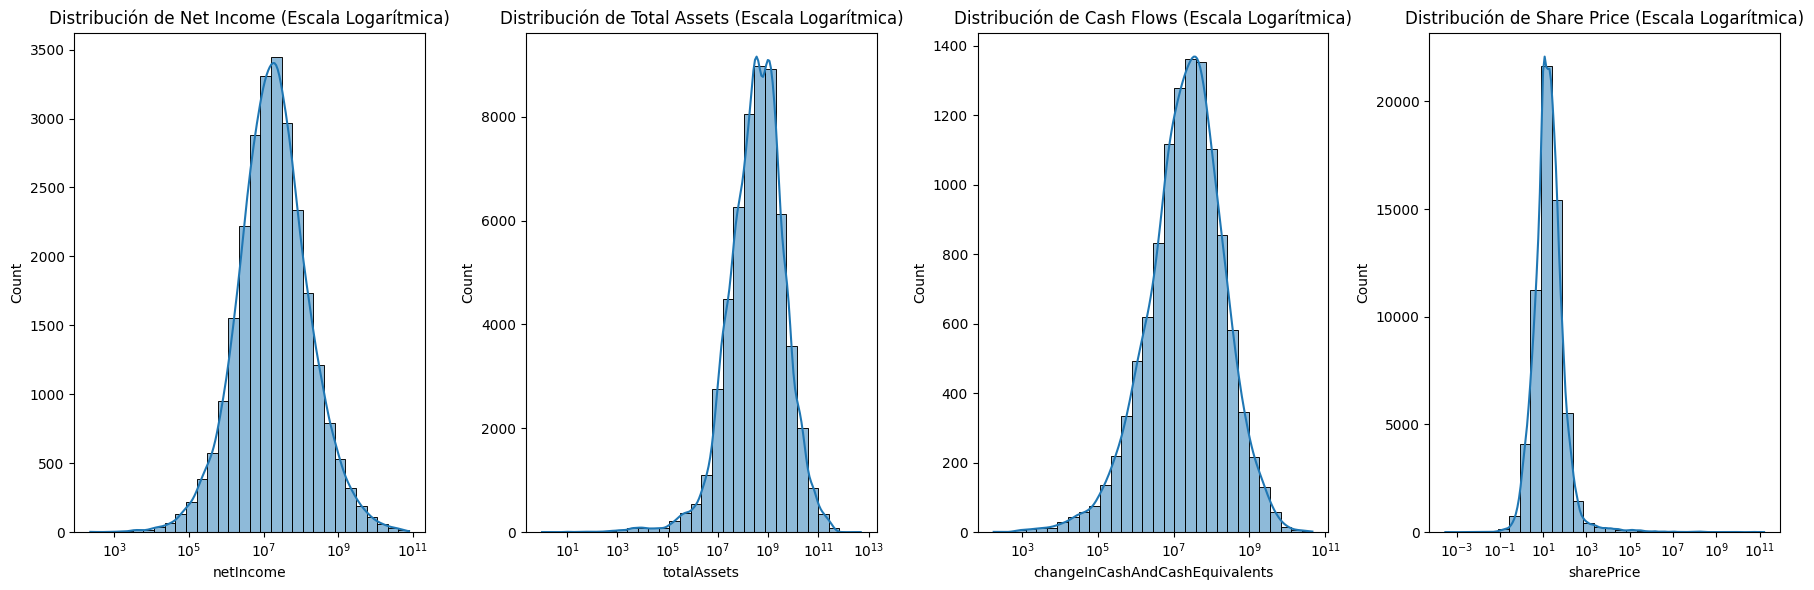

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6)) 

# Net Income
sns.histplot(data=financial_df[financial_df['netIncome'] > 0], x="netIncome", bins=30, kde=True, log_scale=True, ax=axes[0])
axes[0].set_title("Distribución de Net Income (Escala Logarítmica)")

# Total Assets
sns.histplot(data=financial_df[financial_df['totalAssets'] > 0], x="totalAssets", bins=30, kde=True, log_scale=True, ax=axes[1])
axes[1].set_title("Distribución de Total Assets (Escala Logarítmica)")

# Cash Flows
sns.histplot(data=financial_df[financial_df['changeInCashAndCashEquivalents'] > 0], x="changeInCashAndCashEquivalents", bins=30, kde=True, log_scale=True, ax=axes[2])
axes[2].set_title("Distribución de Cash Flows (Escala Logarítmica)")

# Share Price
sns.histplot(data=financial_df[financial_df['sharePrice'] > 0], x="sharePrice", bins=30, kde=True, log_scale=True, ax=axes[3])
axes[3].set_title("Distribución de Share Price (Escala Logarítmica)")

plt.tight_layout()
plt.show()

Como podemos ver en estos histogramas de beneficio neto, activos totales, flujos de caja  y precio de la acción tenemos distribuciones simétricas, sin apenas sesgo o inclinación. Aunque sí cuentan con "outliers". Cabe destacar la utilización de escala logarítmica, esto es debido a que los rangos de los datos son muy diferentes. Por tanto, a la hora de preprocesar, solo tendremos que eliminar outliers, no tendremos que balancear los datos.

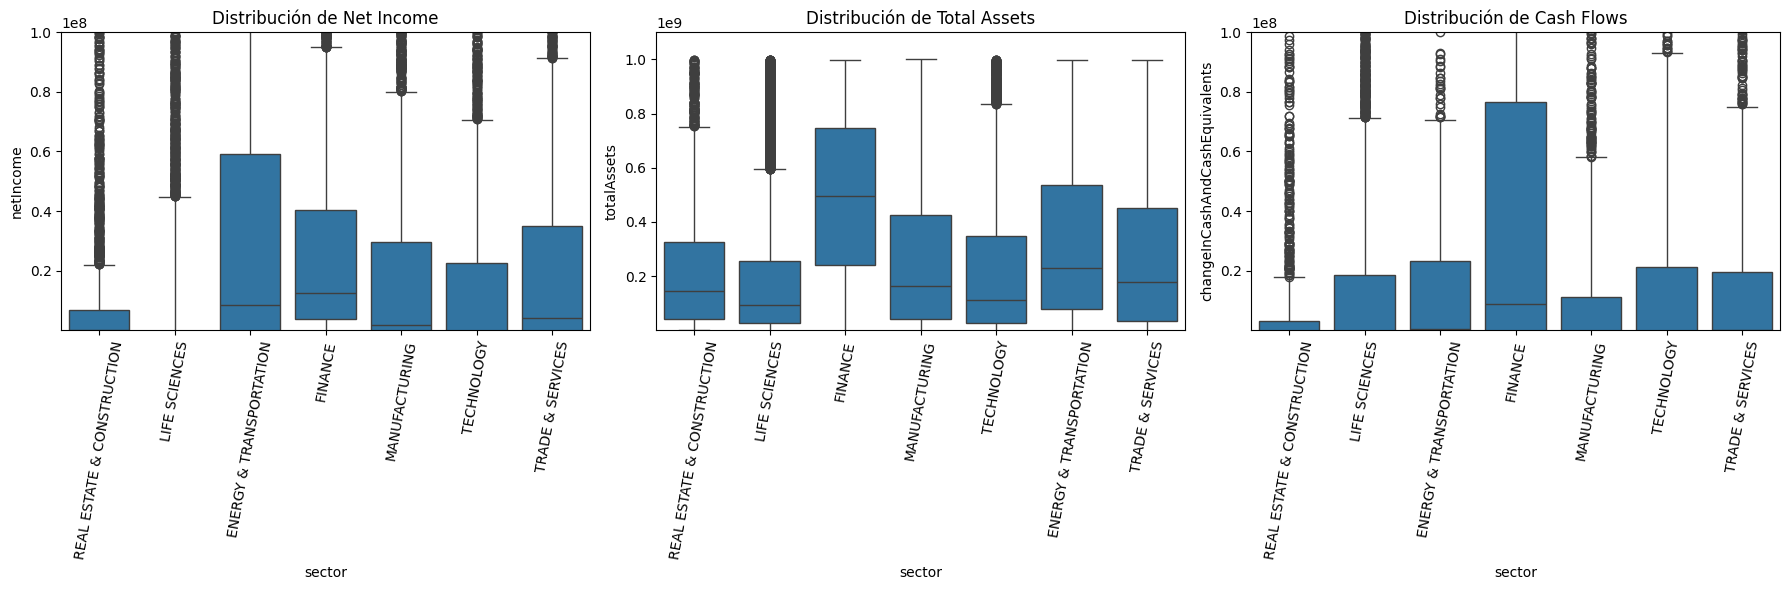

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 

# Net Income
sns.boxplot(x="sector", y="netIncome", data=financial_df, ax=axes[0])
axes[0].set(ylim=(1e0, 1e8)) 
axes[0].tick_params(axis='x', labelrotation=80) 
axes[0].set_title("Distribución de Net Income")

# Total Assets
sns.boxplot(x="sector", y="totalAssets", data=financial_df[financial_df['totalAssets']<1000000000], ax=axes[1])
axes[1].set(ylim=(1e0, 11e8))
axes[1].tick_params(axis='x', labelrotation=80)  
axes[1].set_title("Distribución de Total Assets")


# Cash Flows
sns.boxplot(x="sector", y="changeInCashAndCashEquivalents", data=financial_df, ax=axes[2])
axes[2].set(ylim=(1e0, 1e8)) 
axes[2].tick_params(axis='x', labelrotation=80)
axes[2].set_title("Distribución de Cash Flows")

plt.tight_layout()
plt.show()

Atendiendo a las distribuciones por sector, podemos comprobar que el sector financiero tiene una mediana mayor en ingresos netos, activos totales y flujos de caja que el resto de sectores. También podemos ver la gran variabilidad que sufren sectores como los "real state and construction" y "life sciences", los cuales cuentan con una gran cantidad de outliers. En conclusión, podemos corroborar la gran diferencia entre distintos sectores, los cuales tienen rangos muy distintos de beneficios, activos y flujos de caja, lo que repercute directamente en los ratios y otras estadísticas. Por tanto, va a ser de gran importancia llevar a cabo una correcta normalización o escalado de los datos a la hora de entrenar los modelos.

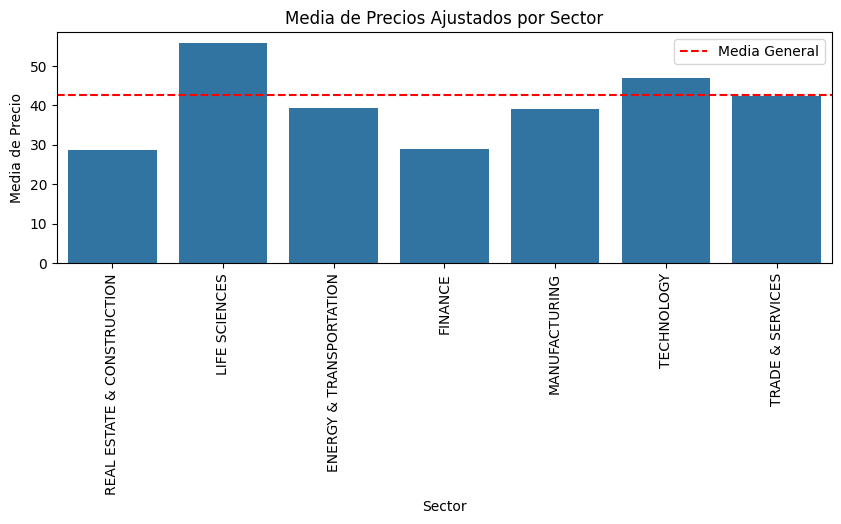

In [10]:
# Limitamos el precio, para evitar outliers
price_limit = financial_df['sharePrice'].quantile(0.985)

# Crear el gráfico de barras
plt.figure(figsize=(10, 3)) 
sns.barplot(x="sector", y="sharePrice", data=financial_df[financial_df['sharePrice']<price_limit], errorbar=None, log_scale=False)

# Agregar una línea para la media general
plt.axhline(financial_df[financial_df['sharePrice']<price_limit]['sharePrice'].mean(), color='red', linestyle='--', label='Media General')

# Personalizar el gráfico
plt.title("Media de Precios Ajustados por Sector")
plt.xlabel("Sector")
plt.ylabel("Media de Precio")
plt.xticks(rotation=90)
plt.legend() 


plt.show()

Por último, si visualizamos los valores medios de los precios ajustados, podemos ver que las acciones de los sectores de "life sciences" y "technology" son los más caros, llegando a superar la media de precios. Cabe destacar que se limitan los precios para poder llevar a cabo un análisis más preciso, eliminando los outliers.

### Análisis de series temporales

A través de gráficos temporales podremos observar las tendencias y la evolución histórica de diferentes atributos, centrándonos en este caso en la evolución de los precios. Lo que nos ayudará a entender mejor el contexto económico y el crecimiento de las empresas y sectores.

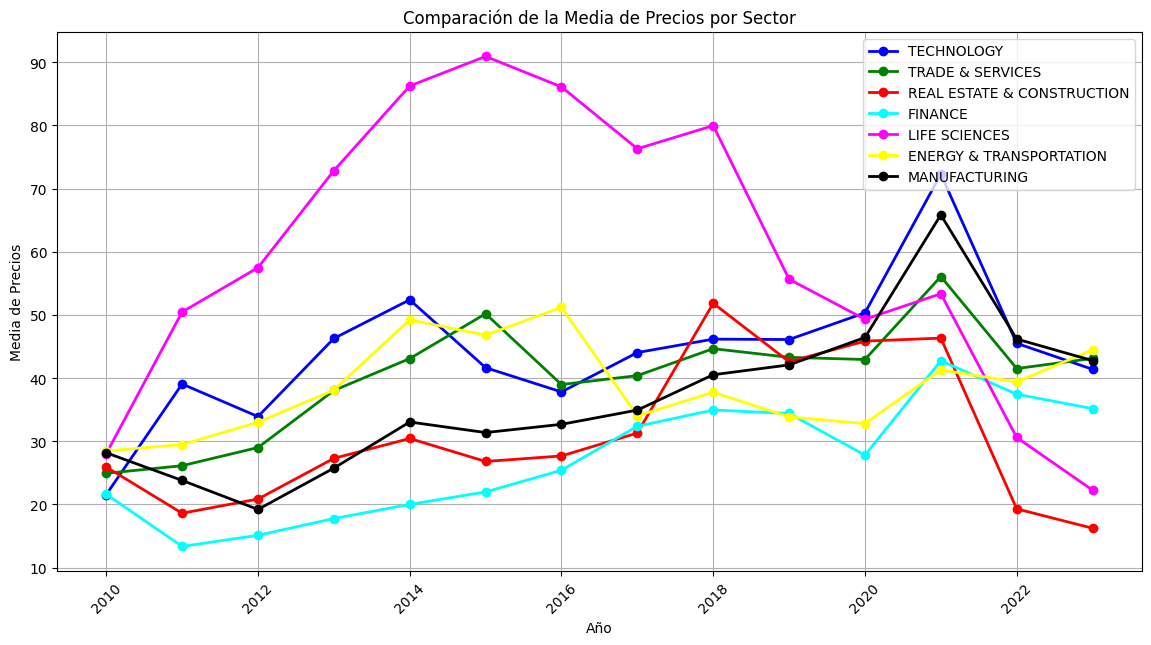

In [11]:
# Lista de sectores
sectores = [
    'TECHNOLOGY',
    'TRADE & SERVICES',
    'REAL ESTATE & CONSTRUCTION',
    'FINANCE',
    'LIFE SCIENCES',
    'ENERGY & TRANSPORTATION',
    'MANUFACTURING'
]

# Colores para cada sector (opcional)
colores = [
    'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'
]

plt.figure(figsize=(14, 7))

# Setear como datetime los valores de fechas para el analisis temporal
financial_df['fiscalDateEnding'] = pd.to_datetime(financial_df['fiscalDateEnding'])

# Calcular y graficar la media de precios para cada sector
for sector, color in zip(sectores, colores):
    sector_df = financial_df[(financial_df['sector'] == sector) & (financial_df['sharePrice'] < price_limit)].copy()
    sector_df['Year'] = sector_df['fiscalDateEnding'].dt.year
    mean_prices = sector_df.groupby('Year')['sharePrice'].mean()
    plt.plot(mean_prices.index, mean_prices.values, label=sector, color=color, linewidth=2, marker='o')

# Personalización del gráfico
plt.title('Comparación de la Media de Precios por Sector')
plt.xlabel('Año')
plt.ylabel('Media de Precios')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Mostrar el gráfico
plt.show()

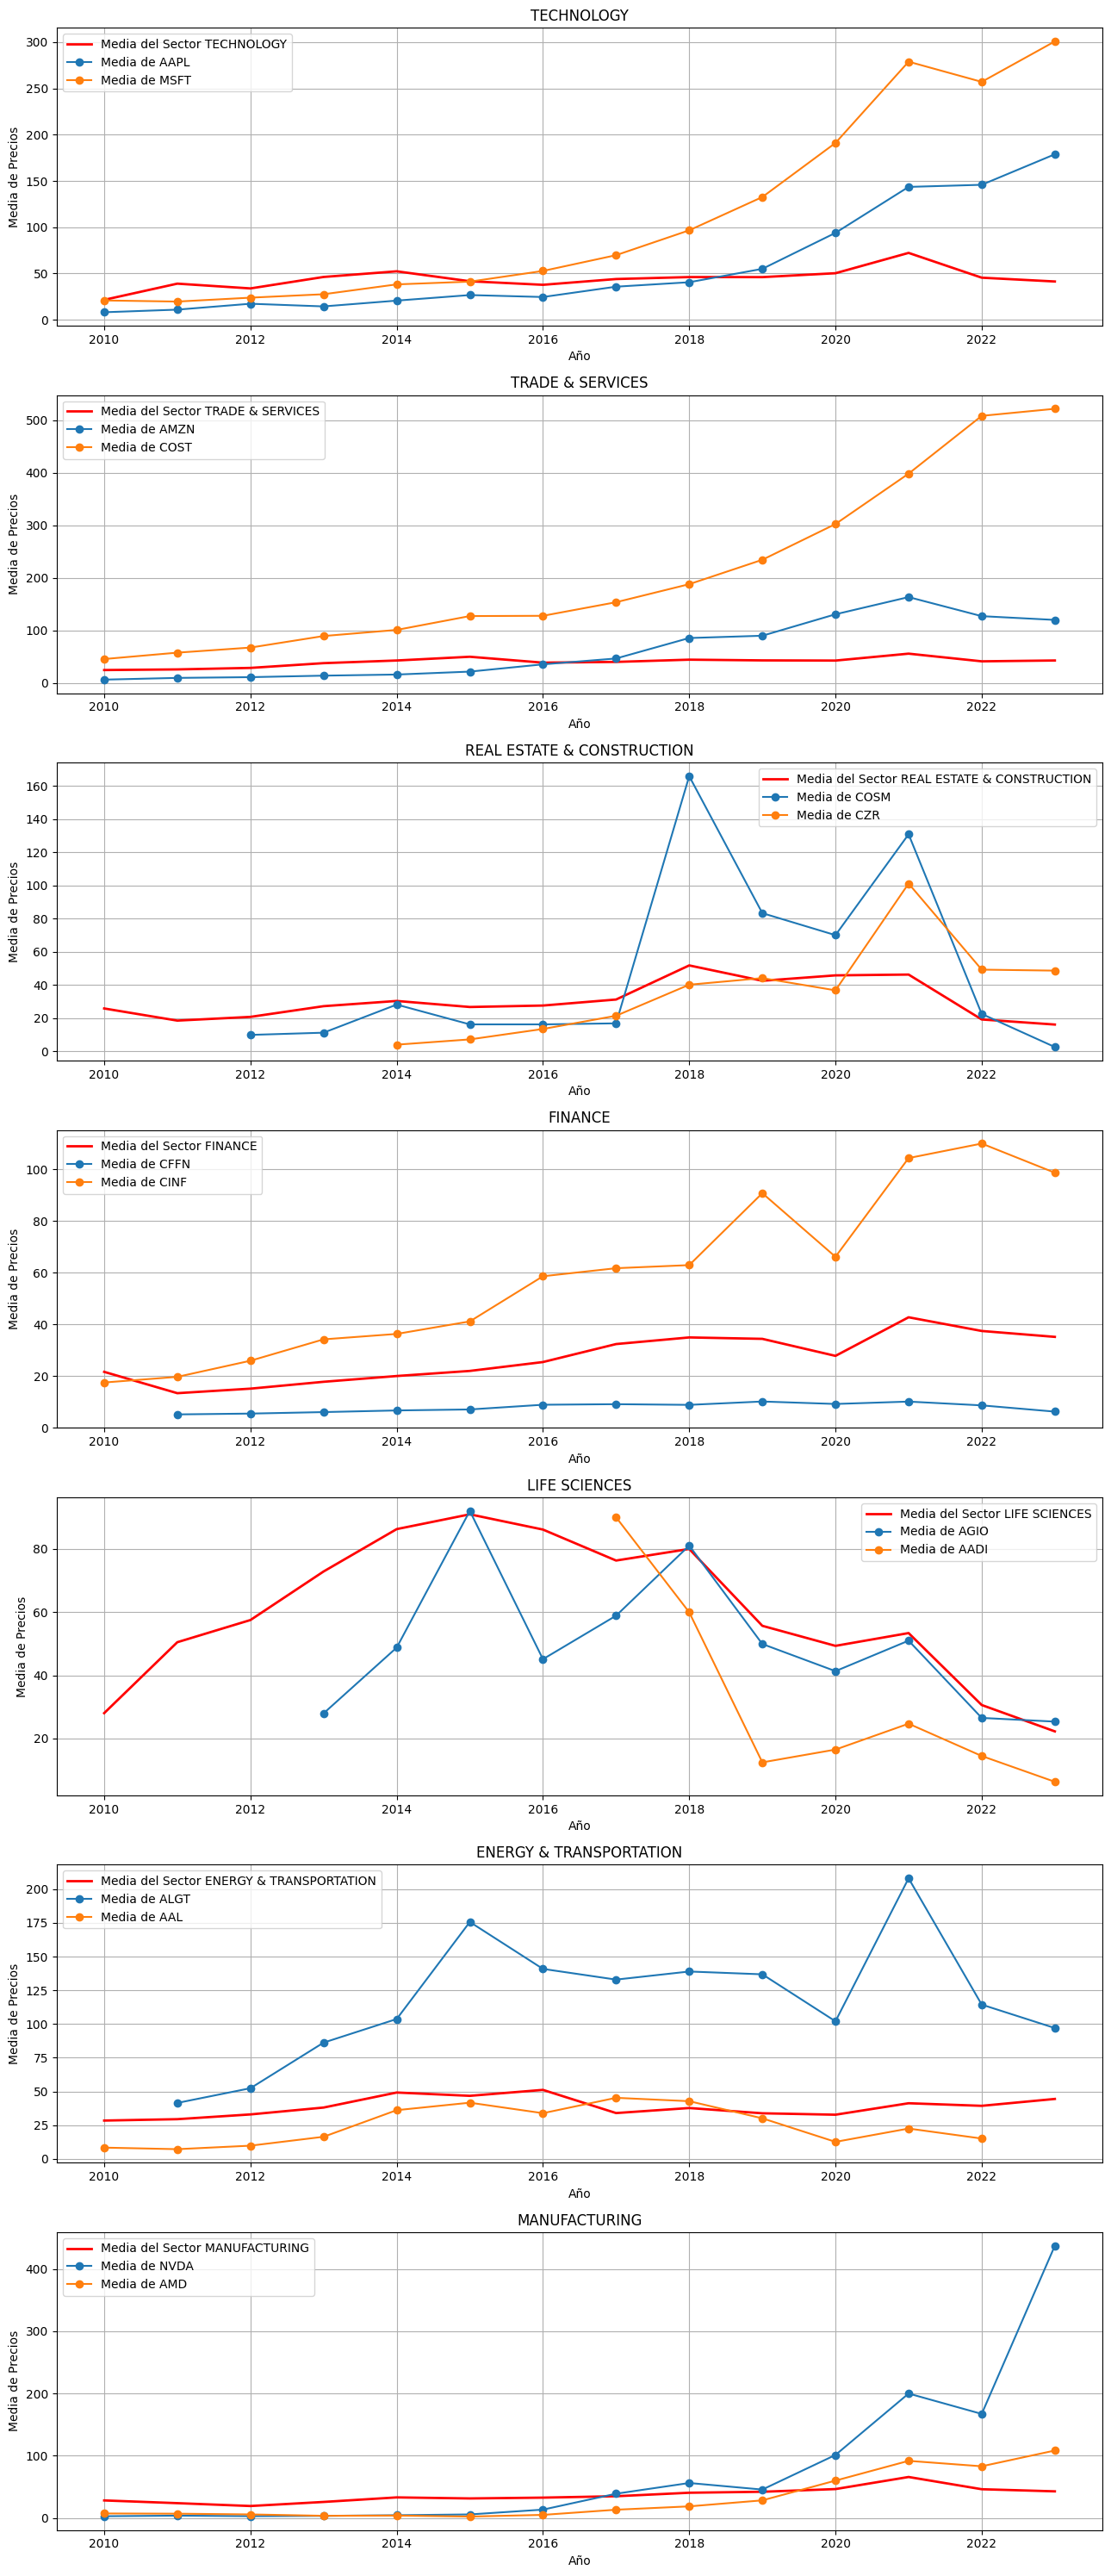

In [12]:
def plot_sector_comparison_subplot(ax, financial_df, sector, companies, price_limit):
    # Filtrar por sector y calcular la media de precios por año, excluyendo outliers
    sector_df = financial_df[(financial_df['sector'] == sector) & (financial_df['sharePrice'] < price_limit)].copy()
    sector_df['Year'] = sector_df['fiscalDateEnding'].dt.year
    mean_prices_sector = sector_df.groupby('Year')['sharePrice'].mean()

    # Gráfico de la media de precios del sector en el eje proporcionado
    ax.plot(mean_prices_sector.index, mean_prices_sector.values, label=f'Media del Sector {sector}', color='red', linewidth=2)

    # Graficar los precios de las acciones de las empresas representativas
    for ticker in companies:
        company_df = financial_df[financial_df['symbol'] == ticker].copy()
        company_df['Year'] = company_df['fiscalDateEnding'].dt.year
        mean_prices_company = company_df.groupby('Year')['sharePrice'].mean()

        # Gráfico de la media de precios de cada empresa en el eje proporcionado
        ax.plot(mean_prices_company.index, mean_prices_company.values, label=f'Media de {ticker}', marker='o')

    # Personalizacion
    ax.set_title(f'{sector}')
    ax.set_xlabel('Año')
    ax.set_ylabel('Media de Precios')
    ax.legend()
    ax.grid(True)

# Configurar la figura de subtramas
fig, axs = plt.subplots(7, 1, figsize=(13, 30))  # 7 filas para los 7 sectores, 1 columna

# Llama a la función para cada sector con las empresas correspondientes y un eje de subtrama
plot_sector_comparison_subplot(axs[0], financial_df, 'TECHNOLOGY', ['AAPL', 'MSFT'], price_limit)
plot_sector_comparison_subplot(axs[1], financial_df, 'TRADE & SERVICES', ['AMZN', 'COST'], price_limit)
plot_sector_comparison_subplot(axs[2], financial_df, 'REAL ESTATE & CONSTRUCTION', ['COSM', 'CZR'], price_limit)
plot_sector_comparison_subplot(axs[3], financial_df, 'FINANCE', ['CFFN', 'CINF'], price_limit)
plot_sector_comparison_subplot(axs[4], financial_df, 'LIFE SCIENCES', ['AGIO', 'AADI'], price_limit)
plot_sector_comparison_subplot(axs[5], financial_df, 'ENERGY & TRANSPORTATION', ['ALGT', 'AAL'], price_limit)
plot_sector_comparison_subplot(axs[6], financial_df, 'MANUFACTURING', ['NVDA', 'AMD'], price_limit)

# Ajustar el layout para que no haya superposición de títulos
plt.tight_layout()
plt.show()


Como podemos comprobar de los graficos anteriores, la media de precios de los diferentes sectores tiene rangos distintos, aunque por lo general, siguen tendencias similares. Además, si miramos los gráficos de las empresas por sector, podemos ver que en ocasiones la media de precios de las empresas sigue la misma tendencia que la media de precios del sector. Por tanto, podemos determinar que añadir información sobre la media del sector en el que se situa una empresa puede resultar de utilidad, ya que se puede usar como "benchmark" o punto de referencia.

# Preprocesado de datos

Gracias al análisis de datos hemos podido sacar diversas conclusiones, que nos ayudarán a tratar y transformar los datos de manera que los modelos tengan información más relevante y con menos ruido. A continuación, se describen las conclusiones extraídas del análisis:
- Se deben calcular aquellos valores faltantes de flujos de caja.
- Se debe llevar a cabo la eliminación de atributos con muchos null values ya que imputar muchos valores faltantes puede dar información falsa al modelo.
- Se deben eliminar los valores infinitos y eliminar outliers, centrándonos sobre todo en aquellos de la variable objetivo.
- A causa de la naturaleza de los datos financieros, las correlaciones existentes entre variables no suponen un problema para el entrenamiento.
- Debido a la diferencia de rango en diferentes atributos tendremos que llevar a cabo una normalización de los mismos.
- Debido a que la media de precios del sector puede resultar importante, debemos computarla y añadirla al dataframe.
- Eliminar columnas con información irrelevante: 
*       'Unnamed: 0' al ser un índice no aporta información útil, 
        'reportedCurrency' al ser todas las compañías pertenecientes la NASDAQ siempre es USD, 
        'industria' debido a que la información del sector ya es suficiente y tenemos una cardinalidad muy grande de industrias.
- Eliminar los años del COVID, para evitar sobreentrenamiento.

In [13]:
preprocessed_df = financial_df.copy()
print(financial_df.shape)

# 1. Eliminar outliers y valores infinitos
price_limit = preprocessed_df['sharePrice'].quantile(0.985)
preprocessed_df = preprocessed_df[(preprocessed_df['sharePrice']<=price_limit) & (preprocessed_df['1y_sharePrice']<=price_limit)]
preprocessed_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2. Computar cashflows
preprocessed_df['cashflowFromFinancing'] = pd.to_numeric(preprocessed_df['cashflowFromFinancing'], errors='coerce')
preprocessed_df['cashflowFromInvestment'] = pd.to_numeric(preprocessed_df['cashflowFromInvestment'], errors='coerce')
preprocessed_df['operatingCashflow'] = pd.to_numeric(preprocessed_df['operatingCashflow'], errors='coerce')
preprocessed_df['changeInCashAndCashEquivalents'] = preprocessed_df['changeInCashAndCashEquivalents'].fillna(
    preprocessed_df['cashflowFromFinancing'] + preprocessed_df['cashflowFromInvestment'] + preprocessed_df['operatingCashflow']
)

# 3. Computar media del sector anual
preprocessed_df['fiscalDateEnding'] = pd.to_datetime(preprocessed_df['fiscalDateEnding'])
preprocessed_df['year'] = preprocessed_df['fiscalDateEnding'].dt.year
mean_price_by_sector_year = preprocessed_df.groupby(['sector', 'year'])['sharePrice'].mean().reset_index(name='meanSectorPrice')
preprocessed_df = preprocessed_df.merge(mean_price_by_sector_year, on=['sector', 'year'])

# 4. Eliminar columnas con +30% de valores faltantes
missing_percentage = preprocessed_df.isnull().mean() * 100
columns_to_drop = missing_percentage[missing_percentage > 30].index
preprocessed_df.drop(columns=columns_to_drop, inplace=True)
# extra: Eliminar las filas donde '1y_sharePrice' es NaN, ya que no tendrán un valor objetivo
preprocessed_df = preprocessed_df.dropna(subset=['1y_sharePrice'])

# 5. Eliminar columnas irrelevantes
columns_to_drop = ['Unnamed: 0', 'reportedCurrency', 'industria']
preprocessed_df.drop(columns=columns_to_drop, inplace=True)

# 6. Eliminar los años del COVID 
preprocessed_df = preprocessed_df.loc[~(preprocessed_df['year'].isin([2020, 2021]))]

print(preprocessed_df.shape, preprocessed_df.columns)

(64635, 74)
(41560, 21) Index(['fiscalDateEnding', 'totalAssets', 'commonStock', 'retainedEarnings', 'totalShareholderEquity', 'incomeTaxExpense', 'netIncome', 'totalLiabilities', 'totalNonCurrentAssets', 'symbol', 'sharePrice', '1y_sharePrice', 'cashAndCashEquivalentsAtCarryingValue', 'propertyPlantEquipment', 'sector', 'P/E', 'ROE', 'ROA', 'bookValue', 'year', 'meanSectorPrice'], dtype='object')



Tras completar el proceso de preprocesamiento, hemos eliminado más de 20.000 filas y 52 columnas de nuestro conjunto de datos. Aunque esta reducción puede parecer significativa, es un paso crucial que nos permite desarrollar modelos más eficaces. Al eliminar el ruido y los datos innecesarios, facilitamos la creación de modelos que no sufran de sobreajuste y que, en consecuencia, tengan una mejor capacidad de generalización.